In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx
from scipy.sparse import csr_matrix
from sklearn import preprocessing
from scipy import ndimage
from keras.datasets import mnist
from hilbert import decode, encode
import math

In [15]:
"""
Helper function for clustering
"""
import scipy.cluster.hierarchy as spc

def hierarchical_clustering(H, alpha=0.7):
    """
    Standard hierarchical clustering, using scipy

    ARGUMENTS

        H       :   (# hidden states, # neurons)-numpy array representing
                    hidden states of the RNN

    RETURNS

        order   :   (# neurons,)-numpy array. order[i] denotes the index of
                    neuron i, based on the order imposed by the hierarchical
                    clustering
    """
    # Covariance matrix
    corr = (H.T @ H) / H.shape[0]

    # Pairwise distanced, based on neuron-neuron correlation vectors
    pdist = spc.distance.pdist(corr)
    # Hierarchical Clustering
    linkage = spc.linkage(pdist, method='complete')
    # Convert to cluster indices
    idx = spc.fcluster(linkage, alpha * pdist.max(), 'distance')
    order = np.argsort(idx)

    # Return the new neuron ordering
    return order

In [16]:
"""
Parameters
"""
# Network parameters
n_rings = 200       # Number of rings in the network
ring_sizes = (2, 8) # (min, max) Number of neurons per ring
eps = 0.025         # Coupling constant
p = 0.1             #Frequency of random connection for small worlds graph
n_in = 8            #Size of the sliding bit window
# Simulation parameters
dt = 1e-2        # Simulation timestep
T_sim = 100       # Simulation duration
seed = -1        # Random seed for the simulation

# Neuron parameters
v_thl = 0.2      # Lower threshold of the schmidt trigger
v_thh = 0.49     # Upper threshold of the schmidt trigger

# Initialization parameters
dv = 1e-2        # Controls the randomness in the initial state
dt_init = 1e-3   
T_init_max = 2 * ring_sizes[1]

# Random seed
if seed == -1: seed = np.random.randint(1e6)
print('Random Seed:', seed)
np.random.seed(seed)

# Generating the ring sizes
R = np.random.choice(np.arange(ring_sizes[0], ring_sizes[1]+1), size=n_rings)
n_h = R.sum() # Total number of neurons
# Idx associated with the first neuron in each ring
nrn1_idx = np.insert(R[:-1].cumsum(), 0, 0)
# Shifted ring indices
shifted_idx = np.concatenate(
    [
        np.roll(np.arange(r_i) + nrn1_idx[i], 1)
        for (i,r_i) in enumerate(R)
    ]
)

#Watts Strogatz Small World Graph
G = nx.watts_strogatz_graph(n = n_rings, k = 2, p = p)
W = nx.to_numpy_array(G)
W = W * eps

Random Seed: 794656


In [17]:
# Setup arrays to store the simulation history
n_ts = int(T_sim / dt) + 1 # Number of timesteps in the simulation
v_cap = np.empty((n_ts,n_h), dtype=float)
v_out = np.empty((n_ts,n_h), dtype=float)

# Schmidt trigger "Activation function"
def f_out(o, v):
     return 1 - np.logical_or( v >= v_thh, np.logical_and(v >= v_thl, o == 0)  )

"""
Initial states for the ring 
"""

# Set the initial state
init_phase = np.random.rand(n_rings)
v_cap[0].fill(0.9)
v_out[0].fill(1)

# Randomly select a single node in each ring to be firing initially
firing_nodes = np.floor(np.random.random(size=n_rings) * (R-1)).astype(int) + nrn1_idx

# Set the selected nodes to have output 1 and random low capacitor values
v_cap[0,firing_nodes] = 0.1 + dv * np.random.rand(n_rings)
v_out[0,firing_nodes] = 0

# Simulate each ring *on its own* for a random amount of time
T_init = np.repeat( np.random.rand(n_rings) * T_init_max, R )
alph_init = np.exp(-dt_init / T_init * T_init_max)
n_ts_init = int(T_init_max / dt_init)
for t in range(n_ts_init):
    # Update capacitors
    u = v_out[0,shifted_idx] 
    v_cap[0] = v_cap[0] * alph_init + u * (1-alph_init)
    # Update outputs
    v_out[0] = f_out(v_out[0], u - v_cap[0])



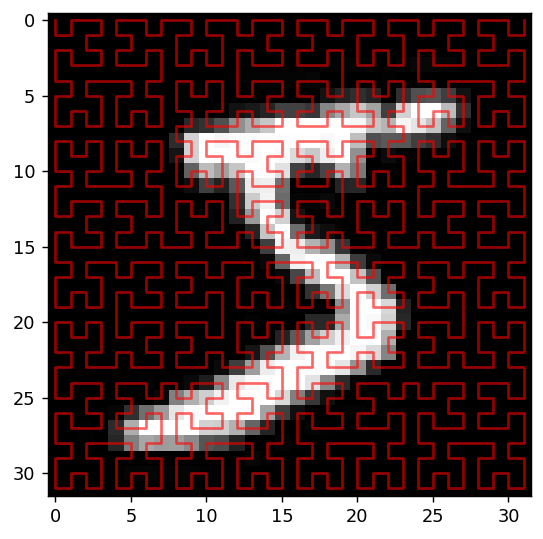

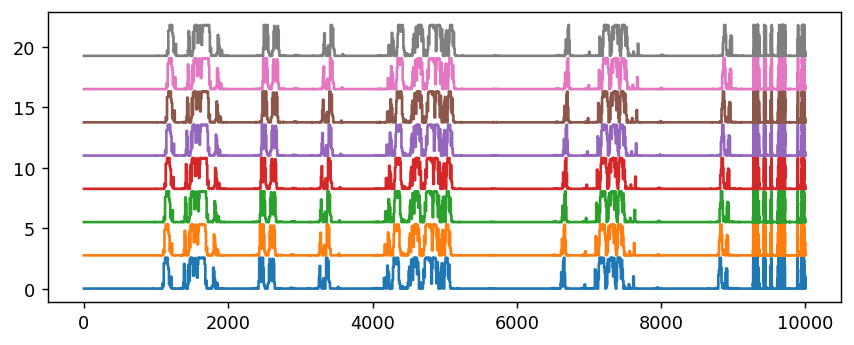

In [18]:
"""
Generate input: MNIST Data according to Hilbert Curve
Creates v_in
"""
(train_X, train_y), (test_X, test_y) = mnist.load_data()

A = train_X[0, :, :]
A = ndimage.zoom(A, 32/28, mode = 'reflect')
# A = preprocessing.normalize(A, norm = 'l2')
A = A * 0.01
N = A.shape[0] # Image width/height in pixels
# Add some noise
A += 0.0 * np.random.randn(*A.shape)

# Hilbert curve positions
logN = int(np.log2(N))
locs = decode(np.arange(N**2), 2, logN)

# Visualization
plt.figure(figsize=(5,5),dpi=128)
plt.imshow(A, cmap='binary_r')
plt.plot(locs[:,0], locs[:,1], c='r', alpha=0.6)
plt.show()

# Creating the sliding window embedding
sw_dim = n_in  # Sliding window dimension
sw = np.zeros((N**2 - sw_dim + 1,sw_dim))
# Traversal of the image A along the Hilbert curve
A_hilbert = A[locs[:,0], locs[:,1]]
# Sliding window of the Hilbert curve traversal
for i in range(sw_dim):
    sw[:,sw_dim-i-1] = A_hilbert[i:][:sw.shape[0]]


n, d  = sw.shape
ratio = n_ts // n
remainder = n_ts % n

# Repeat each entry of sw n_in // n times
sw_repeated = np.repeat(sw, ratio, axis=0)

# Repeat the beginning sequences of sw to fill the remaining elements
if remainder > 0:
    sw_remainder = sw[:remainder]
    sw_repeated = np.concatenate([sw_repeated, sw_remainder], axis=0)


n_ts_show = 1000
plt.figure(figsize=(8,3), dpi=128)
for i in range(sw_dim):
    plt.plot(sw_repeated[:,i] + i * (sw.max() + 0.2), ds='steps-mid')
plt.show()

In [19]:
"""
Simulation
"""
alph = np.exp(-dt)

#Generate adjacency matrix describing input (W_in)
W_in = np.random.binomial(1, 2 * p, size = (n_rings, n_in))
np.fill_diagonal(W_in, 0)

W_in_expanded = np.zeros((n_h,n_in), dtype=int)
# Iterate through each outgoing ring (i) and target ring (j) for the input
for i in range(n_rings):
    for j in range(n_in):
        # Get the indices for the first neuron in the outgoing ring (i) and the second neuron in the target ring (j)
        first_neuron_idx_i = nrn1_idx[i]

        # Get the connection strength from W
        connection_strength = W_in[i, j]

        # Set the connection in W_comb
        if connection_strength > 0:
            W_in_expanded[first_neuron_idx_i, j] = connection_strength
            
W_in_expanded = W_in_expanded * 5 * eps 

W_in_sparse = csr_matrix(W_in_expanded)

#Generate adjacency matrix describing both in-ring connections (W_rot) and combined small-world and
#in-ring connections (W_comb)
W_rot = np.zeros((n_h,n_h), dtype=int)
for i in range(n_rings):
    W_rot[nrn1_idx[i] + np.arange(R[i]),nrn1_idx[i] + np.roll(np.arange(R[i]), 1)] = 1

W_comb = np.zeros((n_h, n_h), dtype=float)
W_comb = W_comb + W_rot
# Iterate through each outgoing ring (i) and target ring (j)
for i in range(n_rings):
    for j in range(n_rings):
        # Get the indices for the first neuron in the outgoing ring (i) and the second neuron in the target ring (j)
        first_neuron_idx_i = nrn1_idx[i]
        second_neuron_idx_j = nrn1_idx[j] + 1  # Second neuron in ring j

        # Get the connection strength from W
        connection_strength = W[i, j]

        # Set the connection in W_comb
        if connection_strength > 0:
            W_comb[first_neuron_idx_i, second_neuron_idx_j] = connection_strength

W_comb_sparse = csr_matrix(W_comb)
# Running the simulation loop
for t in range(n_ts-1):
    # Update capacitors
    # Input from *within* each ring
    #Matrix multiplication implementation
    
    #Vector describing inputs from in-ring and small-world connections
    u = W_comb_sparse @ v_out[t, :] + W_in_sparse @ sw_repeated[t, :]
    #Update capacitor voltage
    v_cap[t+1] = alph * v_cap[t] + (1-alph) * u
    #Update outputs
    v_out[t+1] = f_out(v_out[t], u - v_cap[t+1])

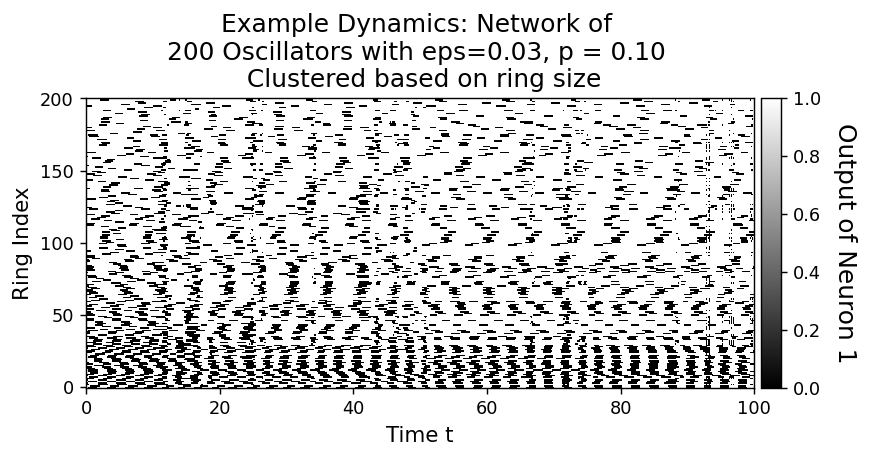

In [20]:
"""
Visualization of the results ordered based on ring size
"""
nrn1_idx_unordered = nrn1_idx[np.argsort(R)]
plt.figure(figsize=(7,3), dpi=128)
plt.title('Example Dynamics: Network of \n%d Oscillators with eps=%0.2f, p = %0.2f \n Clustered based on ring size' % (n_rings, eps, p), size=14)
plt.xlabel('Time t', size=12)
plt.ylabel('Ring Index', size=12)
# Heatmap
im = plt.imshow(
    v_out[:,nrn1_idx_unordered].T, 
    extent=(0,T_sim,-0.5,n_rings+0.5),
    aspect='auto', interpolation='none', vmin=0, vmax=1, cmap='binary_r',
    origin='lower'
)
# colorbar
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="3%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.ax.set_ylabel('Output of Neuron 1', size=14, rotation=-90, labelpad=20)

plt.show()

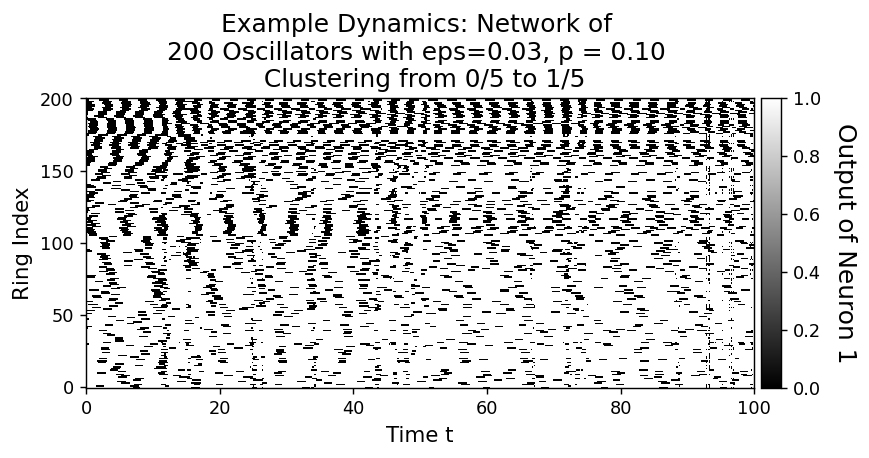

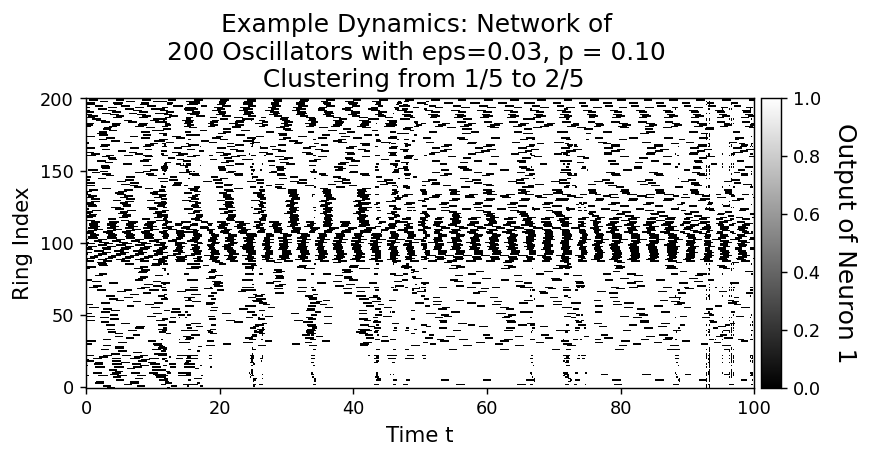

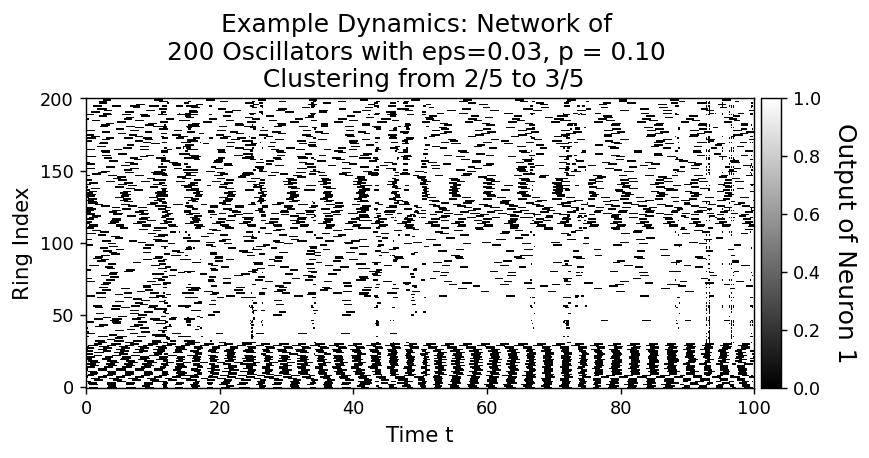

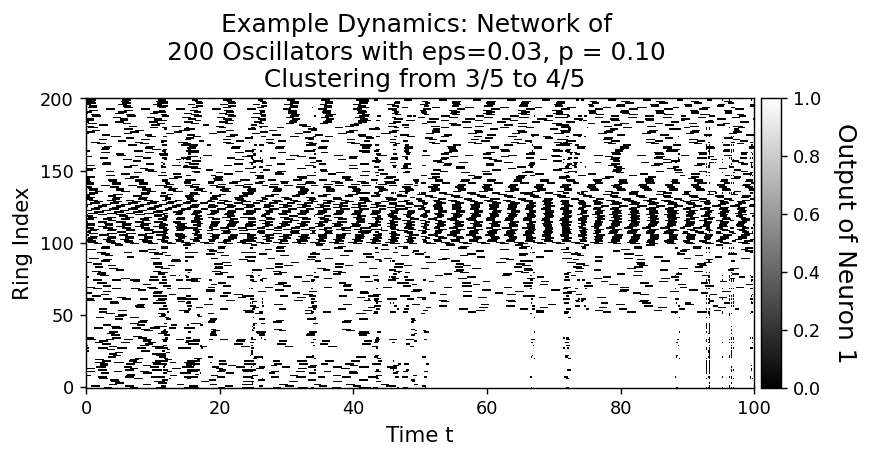

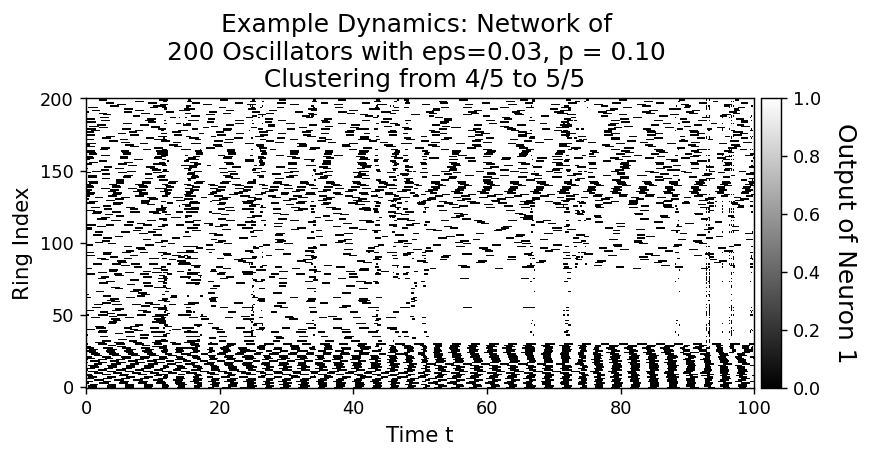

In [21]:
"""
Visualization of the results ordered with clustering algorithm
"""

for i in range(5):
    # Clustering by output of neuron 0 in each ring
    order = hierarchical_clustering(v_out[i * n_ts//5: (i+1) * n_ts//5,nrn1_idx], alpha=0.2)
    nrn1_idx_reordered = nrn1_idx[order]
    plt.figure(figsize=(7,3), dpi=128)
    plt.title('Example Dynamics: Network of \n%d Oscillators with eps=%0.2f, p = %0.2f \n Clustering from %d/5 to %d/5' % (n_rings, eps, p, i, i+1), size=14)
    plt.xlabel('Time t', size=12)
    plt.ylabel('Ring Index', size=12)
    # Heatmap
    im = plt.imshow(
        v_out[:,nrn1_idx_reordered].T, 
        extent=(0,T_sim,-0.5,n_rings+0.5),
        aspect='auto', interpolation='none', vmin=0, vmax=1, cmap='binary_r',
        origin='lower'
    )
    # colorbar
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="3%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.ax.set_ylabel('Output of Neuron 1', size=14, rotation=-90, labelpad=20)

    plt.show()

In [22]:
R

array([5, 5, 5, 7, 4, 5, 2, 2, 5, 2, 4, 7, 5, 3, 5, 5, 2, 5, 6, 3, 7, 2,
       4, 3, 7, 8, 2, 4, 5, 8, 6, 2, 2, 2, 8, 4, 4, 2, 6, 8, 7, 2, 7, 5,
       7, 2, 7, 3, 6, 5, 3, 4, 2, 3, 3, 7, 3, 7, 5, 5, 3, 2, 8, 3, 2, 2,
       4, 8, 5, 6, 7, 5, 8, 7, 2, 3, 8, 6, 5, 7, 8, 5, 6, 7, 4, 7, 8, 3,
       5, 8, 2, 2, 7, 4, 2, 7, 3, 8, 2, 8, 4, 5, 7, 6, 4, 4, 6, 4, 8, 4,
       2, 2, 5, 3, 3, 7, 3, 4, 5, 7, 8, 2, 3, 5, 2, 8, 7, 8, 6, 5, 2, 7,
       2, 4, 4, 4, 8, 6, 5, 5, 4, 5, 7, 8, 7, 2, 4, 4, 2, 4, 5, 6, 5, 3,
       2, 2, 2, 5, 7, 6, 8, 8, 8, 6, 4, 2, 7, 6, 5, 8, 7, 7, 2, 3, 5, 7,
       6, 2, 4, 5, 6, 5, 6, 3, 3, 7, 4, 3, 7, 3, 6, 7, 8, 4, 8, 6, 5, 7,
       6, 4])

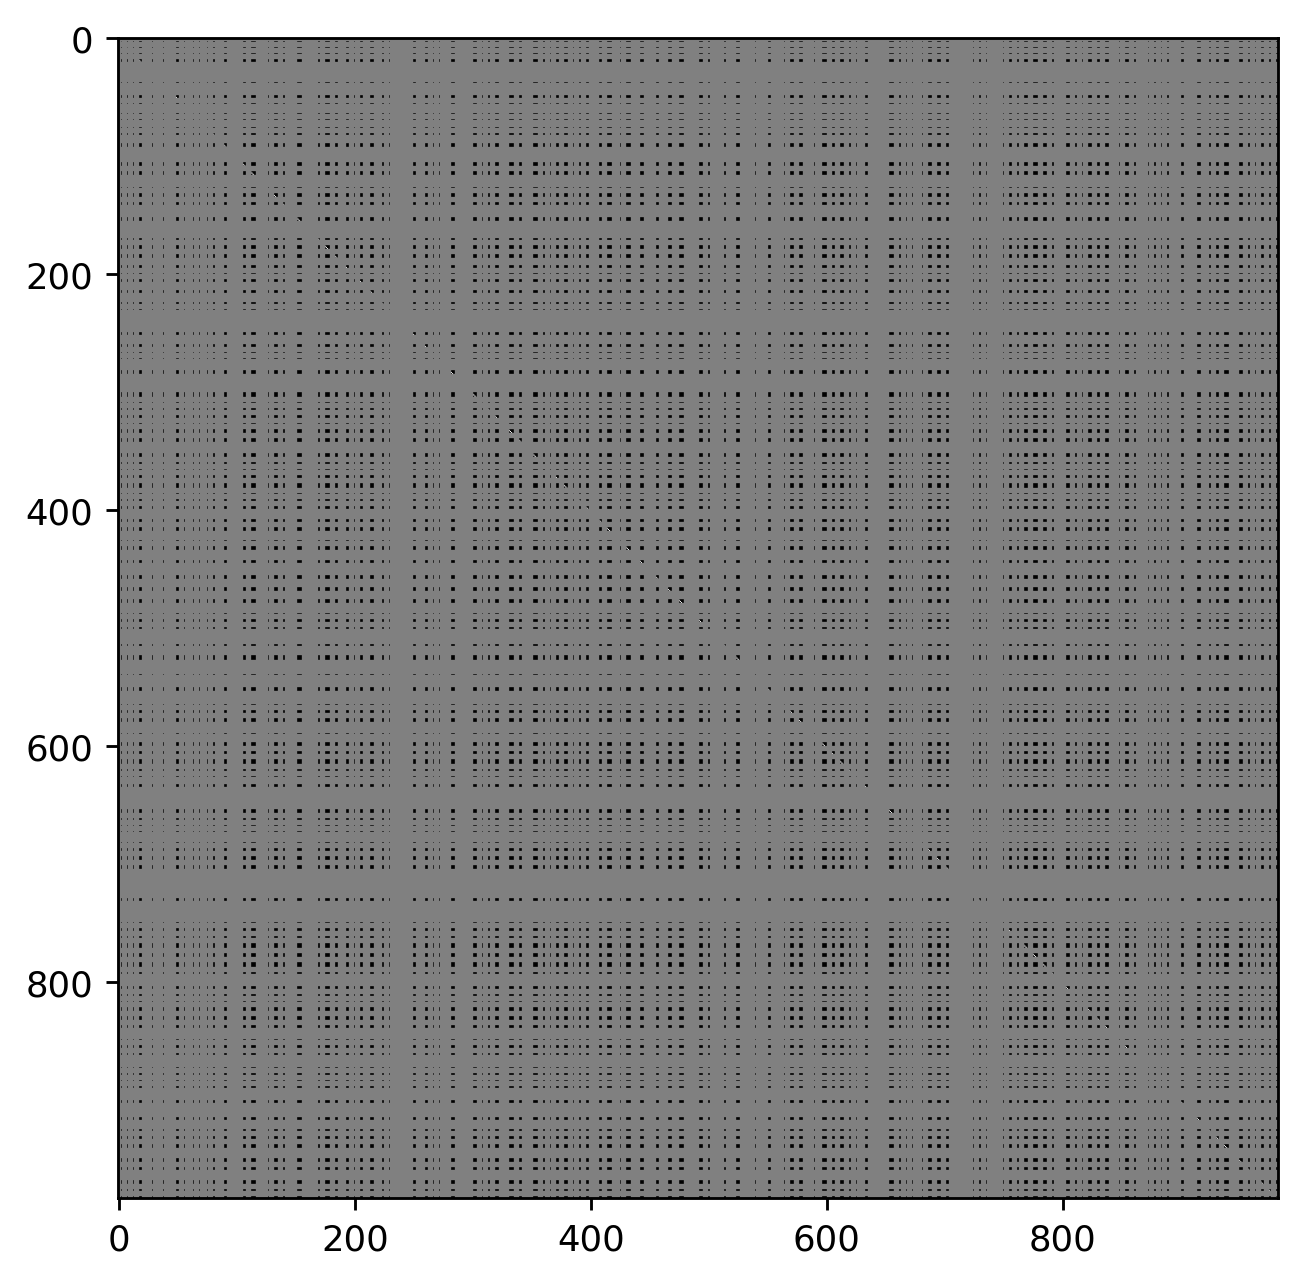

In [23]:
plt.figure(figsize=(6,6), dpi=256)
plt.imshow(W_comb, cmap='gray')
for i in range(n_rings):
    plt.axvline(nrn1_idx[i]-0.5, c='gray')
    plt.axhline(nrn1_idx[i]-0.5, c='gray')
plt.show()

In [24]:
"""
Create v_samp which will sample from v_out based on the number of repititions used to create the input above.
Use v_samp to train a linear classifier.
"""
v_os = v_out[::ratio]
v_os = v_os.reshape(-1)
print(v_os.shape)

(1093096,)
